# Data product guide

- `{NUTS1}.parquet` - GeoParquet. ZSTD compressed, with GeoArrow geometry encoding and covering bbox for fast spatial queries.
- `{NUTS1}_morphotopes.parquet` - GeoParquet. ZSTD compressed, with GeoArrow geometry encoding and covering bbox for fast spatial queries.
- `label_name.json`
- `pen_portraits.json`
- `morphotope_data.parquet` - all characters for non-outlier morphotopes - used to build the taxonomy. Parquet, Snappy compressed
- `ward_linkage.npy`
- `{NUTS1}_data.parquet` - Parquet, ZSTD compressed

In [1]:
import json

import numpy as np
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# set to a local or cloud directory
data_product_dir = '/data/uscuni-ulce/data_product'

## Plotting building data

The results from the clustering are assigned to buildings and are stored in ``buidings/{NUTS1}.parquet``. The data has the following columns:
- ``geometry`` - the geometry of the building.
- ``morphotope_id`` - the morphotope, the building falls into.
- ``initially_noise`` - whether the morphotope and the building were initially noise and assigned to a cluster later.
- ``level_1_label`` - the level 1 classiffication of the building, corresponding to a cut of the hierarchy of 2500.
- ``level_2_label`` - the level 2 classiffication of the building, corresponding to a cut of the hierarchy of 1600.
- ``level_3_label`` - the level 3 classiffication of the building, corresponding to a cut of the hierarchy of 1000.
- ``level_4_label`` - the level 4 classiffication of the building, corresponding to a cut of the hierarchy of 700.
- ``level_5_label`` - the level 5 classiffication of the building, corresponding to a cut of the hierarchy of 500.
- ``level_6_label`` - the level 6 classiffication of the building, corresponding to a cut of the hierarchy of 300.
- ``level_7_label`` - the level 7 classiffication of the building, corresponding to a cut of the hierarchy of 200.

You can quickly search the file using the bounding boxes in the ``EPSG:3035`` projection.

In [19]:
from shapely import box
gpd.GeoSeries([box(14.367886,50.092613,14.414921,50.112102)], crs=4326).to_crs(3035).total_bounds

array([4633248.79096925, 3007112.90090362, 4636735.43400836,
       3009478.5981092 ])

In [3]:
%%time
buildings_subset = gpd.read_parquet(f'{data_product_dir}/cz0.parquet', bbox=(4633248, 3007112, 4636735, 3009478))

CPU times: user 725 ms, sys: 467 ms, total: 1.19 s
Wall time: 448 ms


<Axes: >

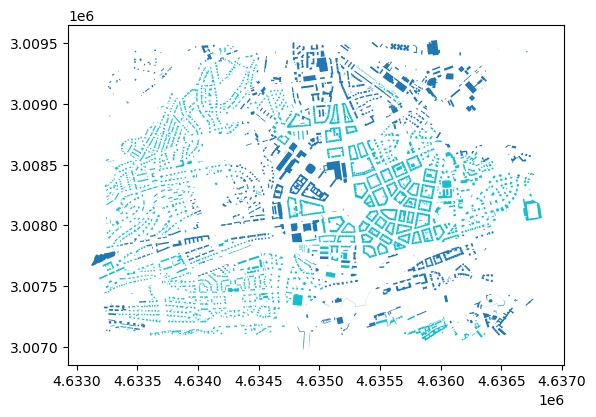

In [4]:
buildings_subset.plot(column='level_1_label', categorical=True)

## Data

### Building-level data

In [6]:
data = pd.read_parquet(f"{data_product_dir}/cz0_data.parquet")
data.head()

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,licBAD,misBAD,midBAD
51289_956483,124.380966,45.522812,0.0,0.513258,5.0,18.040710,1.012931,0.596085,7.803086,1.393862,...,0.356651,1.002488,0.404339,27.314951,3.396414,3.396414,48.194645,42.634842,167.245316,122.123451
51289_956636,11.252568,17.124670,0.0,0.272640,3.0,30.028931,0.855039,0.428266,3.320516,0.805084,...,0.356651,1.002488,0.404339,27.314951,3.396414,3.396414,79.993858,42.634842,167.245316,122.123451
51289_956514,94.360451,38.971008,0.0,0.628630,4.0,0.047201,1.000023,0.856729,6.909484,0.002814,...,0.356651,1.002488,0.404339,27.314951,3.396414,3.396414,26.373606,42.634842,167.245316,122.123451
51289_956762,449.424896,90.864792,0.0,0.487262,4.0,0.583978,1.000070,0.471208,17.067406,0.068636,...,0.474598,1.001944,0.491401,34.468868,5.011787,5.011787,218.161392,161.731567,218.161392,218.161392
51289_984296,28.429281,21.330400,0.0,0.635632,4.0,0.059518,1.000008,0.967430,3.771203,0.001958,...,0.968588,1.007695,0.649163,7.746296,1.393252,1.393252,NaN,NaN,145.320297,161.600830


<Axes: >

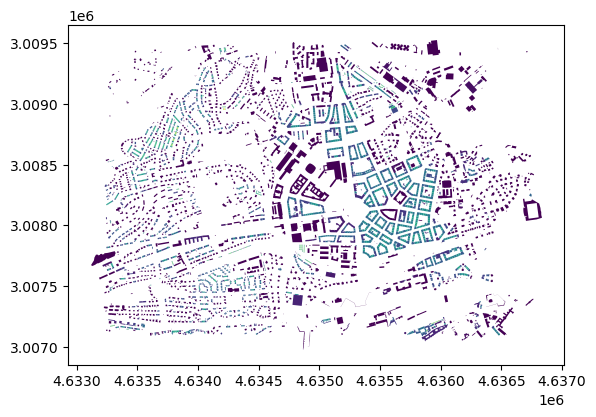

In [10]:
joined = buildings_subset.join(data, how='left')

joined.plot('mtbSWR')

### Morphotope-level data

For each non-noise morphotope, we release aggregated morphometric values for a direct comparison.

In [48]:
morphotope_data = pd.read_parquet('/data/uscuni-ulce/data_product/morphotope_data.parquet')
morphotope_data

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbSqu,ssbERI,ssbElo,libNCo,ldbPWL,ltcBuA,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre
4_0_1,0.987137,1.433775,-0.003262,-1.949620,-0.424706,0.483494,-2.019151,-0.08234,0.208525,0.081287,...,-1.315770,0.462303,-0.613538,0.493512,1.521773,1.521773,3.654263,4.850005,0.149898,3.887056
4_0_10,0.999498,1.196410,-0.003262,-0.789406,-0.342916,0.486163,-1.535531,-0.08234,0.182541,-0.233554,...,-0.153381,0.395069,0.056334,0.486932,1.216988,1.216988,1.178967,1.099998,0.149898,0.893068
4_0_100,-0.137159,-0.163803,-0.003262,-0.466113,-0.366240,-0.856290,0.731951,-0.08234,-0.106013,-0.458441,...,-0.521085,-0.580478,-0.558703,-0.081649,-0.032863,-0.032863,-0.203994,-0.233173,0.149898,-0.317867
4_0_101,-0.459409,-0.503755,-0.003262,0.343387,-0.298401,0.174042,0.749521,-0.08234,0.061081,-1.357987,...,-0.639787,-1.158760,-1.204788,0.178917,0.258876,0.258876,-0.310458,-0.336999,0.149898,-0.233568
4_0_102,2.676117,2.777188,-0.003262,-3.146540,-0.373569,0.244430,-2.962140,-0.08234,0.327391,0.081287,...,-2.175354,0.401162,-1.384519,0.805433,1.585684,1.585684,0.688806,0.228241,0.149898,0.615805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152511_809_0,0.378060,0.452225,-0.003262,0.986065,-0.155806,-0.260933,1.028036,-0.08234,-0.345792,1.340653,...,1.064571,0.742462,1.252631,-0.467798,-0.553549,-0.553549,-0.185301,-0.115341,0.149898,-0.399705
152511_8_0,0.288760,0.448556,-0.003262,-0.052106,-0.203213,0.491686,-0.223015,-0.08234,-0.356453,1.340653,...,0.193617,0.842279,0.855323,-0.447989,-0.568171,-0.568171,-0.077163,-0.033948,0.149898,-0.351100
152511_8_1,0.493941,0.612191,-0.003262,0.223337,-0.193634,-1.845646,0.758600,-0.08234,-0.345008,1.340653,...,0.903872,0.536746,0.971907,-0.478463,-0.501992,-0.501992,0.078303,-0.074908,0.149898,-0.265919
152511_8_2,0.603987,0.717053,-0.003262,0.284544,-0.195905,0.488063,-0.253222,-0.08234,-0.333686,1.340653,...,0.153683,0.840281,1.026858,-0.438514,-0.445666,-0.445666,-0.183356,-0.211640,0.149898,-0.405401


## Taxonomic tree

The data for the taxonomic tree - ``ward_linkage_10.npy`` - is in ``scipy.cluster.hierarchical.linkage`` format. 

The input data for the taxonomy is a subset of morphotopes and their characteristics. Only extreme outliers were dropped from the full morphotope list when producing the taxonomy.

In [23]:
linkage_matrix = np.load('/data/uscuni-ulce/data_product/ward_linkage_10.npy')

Since the linkage matrix is large - around 500,000 observations - we do not plot labels

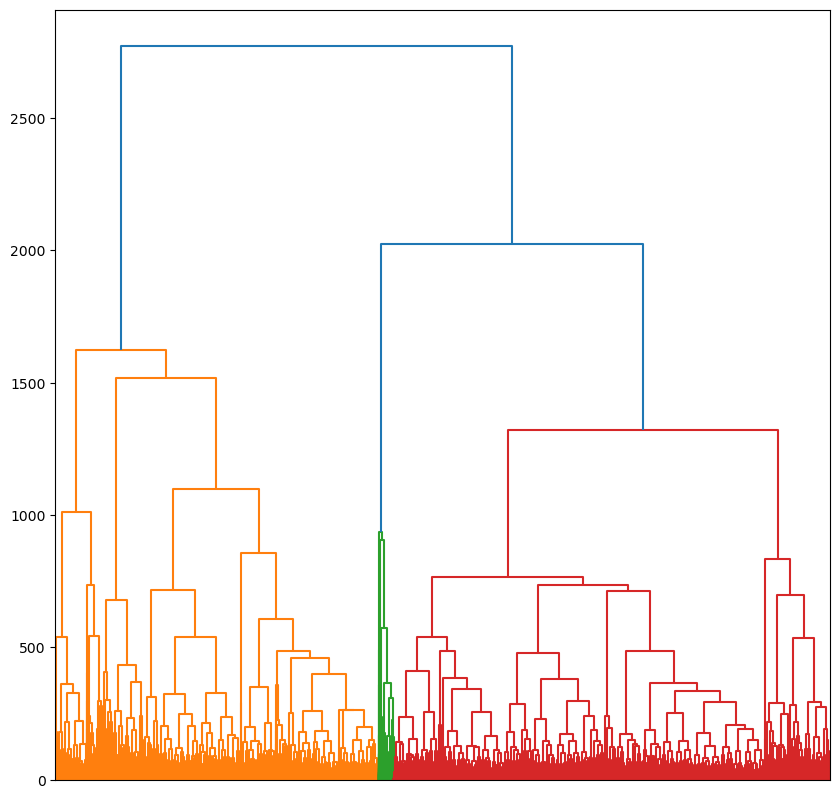

In [24]:
## final dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

You can use fcluster to cut it at arbitrary values.

In [26]:
cutoffs = [1000, 1600, 2500]

cluster_frame = []
for c in cutoffs:
    clusters = fcluster(linkage_matrix, t=c, criterion='distance')
    cluster_frame.append(pd.Series(clusters))

cluster_frame = pd.concat(cluster_frame, axis=1)
cluster_frame.columns = cutoffs
cluster_frame.index = morphotope_data.index
cluster_frame

,1000,1600,2500
4_0_1,1,1,1
4_0_10,1,1,1
4_0_100,7,4,2
4_0_101,7,4,2
4_0_102,1,1,1
...,...,...,...
152511_809_0,4,2,1
152511_8_0,3,2,1
152511_8_1,5,2,1
152511_8_2,5,2,1


## Linking the new cuts to the buildings

You have to link back the cluster to the buildings to plot using the morphotope ID. Some buildings are not part of morphotopes, or are part of outlier morphotopes. They come out as NA in the mapping, and they have to be handled seperately. 

In [28]:
new_clusters = buildings_subset.morphotope_id.map(cluster_frame[1000].to_dict())

<Axes: >

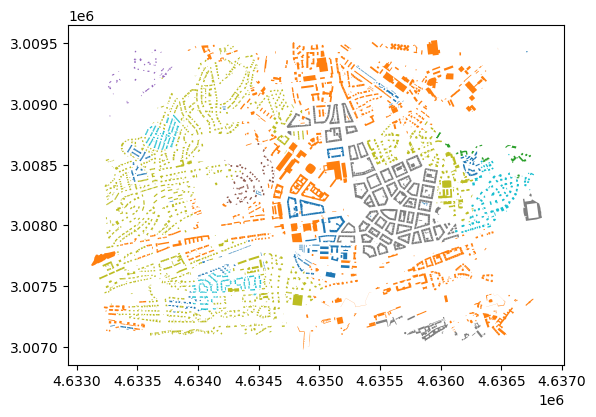

In [29]:
buildings_subset.plot(column=new_clusters.fillna(-1), categorical=True)

In this case we are mapping the morphotopes to a cut that exists, so we can verify the results


In [30]:
from pandas.testing import assert_series_equal

# drop outliers and noise and compare only morphotopes that are part of the clustering
new_assignment = new_clusters.dropna().astype(int)
old_assignment = buildings_subset.loc[~buildings_subset.initially_noise, 'level_3_label']

assert_series_equal(new_assignment, old_assignment, check_names=False)

## Handling noise and outliers

The easiest way to deal with outliers is to use the buildings.parquet file,  the initially noise column and the lowest level to the custom cut.

In [31]:
mapping_level = 'level_7_label'

In [32]:
# create a dictionary that maps the old assignemnts at the specified level to the new cluster values
new_assignment_mapping = new_assignment.drop_duplicates()
new_assignment_mapping = pd.Series(new_assignment_mapping.values, buildings_subset.loc[new_assignment_mapping.index, mapping_level])
new_assignment_mapping

level_7_label
6      1
88     7
102    8
47     5
66     6
18     2
40     4
dtype: int64

In [33]:
new_noise = new_clusters[new_clusters.isna()].index
new_clusters.loc[new_noise] = buildings_subset.loc[new_noise, mapping_level].map(new_assignment_mapping)

<Axes: >

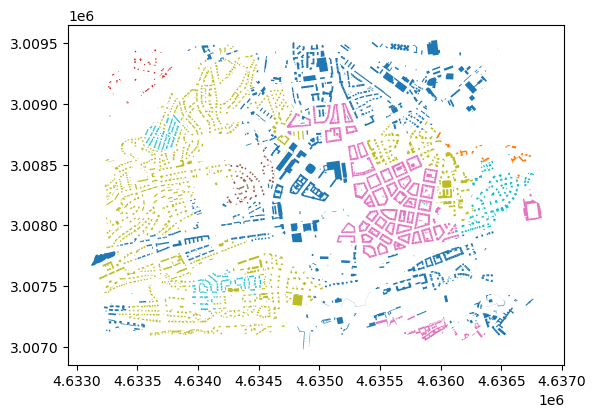

In [34]:
buildings_subset.plot(column=new_clusters, categorical=True)

Alternatively you can create a custom noise assignment function directly using the morphological characteristics in the ``/data/`` folder.

## Naming clusters & branches

In [37]:
with open(f"{data_product_dir}/label_name.json", 'r') as f:
    cluster_names = json.load(f)

In [38]:
cluster_names

{'1': {'1': 'Incoherent Fabric', '2': 'Coherent Fabric'},
 '2': {'1': 'Incoherent Large-Scale Fabric',
  '2': 'Incoherent Small-Scale Fabric',
  '3': 'Coherent Interconnected Fabric',
  '4': 'Coherent Dense Fabric'},
 '3': {'1': 'Incoherent Large-Scale Homogeneous Fabric',
  '2': 'Incoherent Large-Scale Heterogeneous Fabric',
  '3': 'Incoherent Small-Scale Linear Fabric',
  '4': 'Incoherent Small-Scale Sparse Fabric',
  '5': 'Incoherent Small-Scale Compact Fabric',
  '6': 'Coherent Interconnected Fabric',
  '7': 'Coherent Dense Disjoint Fabric',
  '8': 'Coherent Dense Adjacent Fabric'}}

First level keys capture the level of labels, second level the mapping of a label to a name.

In [39]:
with open(f"{data_product_dir}/pen_portraits.json", 'r') as f:
    cluster_descriptions = json.load(f)

In [40]:
cluster_descriptions

{'1': {'Incoherent Fabric': 'Incoherent fabric covers a wide morphological variety, with a common theme of partial or complete breakage of the traditional structural roles of streets, plots, and buildings. Common for modernist period, post-modern, and industrial developments, this branch has less typically less connected street networks and may showcase buildings facing open spaces and internal parts of blocks rather than streets. At the same time, it contains less defined village developments.',
  'Coherent Fabric': 'In coherent fabric, all streets, plots, and buildings take their traditional structural roles in defining the spatial arrangement of the urban form. It is common for traditional European development with densely connected street networks and legible plot structure, facilitating direct relation between buildings and streets.'},
 '2': {'Incoherent Large-Scale Fabric': 'Incoherent large-scale fabric captures typically urban development composed of buildings larger than the a

## Plotting morphotope delineation

The results from the morphotope delineation are stored in ``morphotopes/{NUTS1}.parquet``. The data has the following columns:
- ``geometry`` - the geometry of the building.
- ``morphotope_id`` - the morphotope, the building falls into.
- ``initially_noise`` - whether the morphotope and the building were initially noise and assigned to a cluster later.
- ``level_1_label`` - the level 1 classiffication of the building, corresponding to a cut of the hierarchy of 2500.
- ``level_2_label`` - the level 2 classiffication of the building, corresponding to a cut of the hierarchy of 1600.
- ``level_3_label`` - the level 3 classiffication of the building, corresponding to a cut of the hierarchy of 1000.
- ``level_4_label`` - the level 4 classiffication of the building, corresponding to a cut of the hierarchy of 700.
- ``level_5_label`` - the level 5 classiffication of the building, corresponding to a cut of the hierarchy of 500.
- ``level_6_label`` - the level 6 classiffication of the building, corresponding to a cut of the hierarchy of 300.
- ``level_7_label`` - the level 7 classiffication of the building, corresponding to a cut of the hierarchy of 200.

You can quickly search the file using the bounding boxes in the ``EPSG:3035`` projection.

In [41]:
%%time
morphotope_subset = gpd.read_parquet(f'{data_product_dir}/cz0_morphotopes.parquet', bbox=(4633248, 3007112, 4636735, 3009478))

CPU times: user 1.07 s, sys: 778 ms, total: 1.85 s
Wall time: 1.81 s


In [42]:
morphotope_subset

,geometry,morphotope_id,initially_noise,level_1_label,level_2_label,level_3_label,level_4_label,level_5_label,level_6_label,level_7_label
2690,"POLYGON ((4632562.899 3007004.802, 4632547.374...",69333_849_709,False,1,1,1,1,2,4,6
4461,"POLYGON ((4633261.396 3007177.453, 4633261.396...",69333_849_-1621,True,2,4,8,17,24,55,101
2585,"POLYGON ((4632969.157 3007946.694, 4632961.8 3...",69333_849_614,False,2,4,7,13,20,48,88
2653,"POLYGON ((4631971.302 3007471.731, 4631970.455...",69333_849_676,False,1,1,1,1,1,1,1
2609,"POLYGON ((4632987.333 3007328.425, 4632987.333...",69333_849_636,False,2,4,7,12,18,41,77
...,...,...,...,...,...,...,...,...,...,...
2638,"POLYGON ((4633300.974 3008347.325, 4633283.253...",69333_849_662,False,2,4,7,12,19,45,83
4171,"POLYGON ((4633456.577 3008587.372, 4633456.576...",69333_849_-1331,True,2,4,8,17,24,55,101
2506,"POLYGON ((4633639.214 3008630.76, 4633639.213 ...",69333_849_543,False,2,4,8,17,24,55,103
2562,"POLYGON ((4633898.427 3008906.627, 4633910.712...",69333_849_594,False,2,4,7,13,20,48,90


These align with the labels allocated to buildings.

<Axes: >

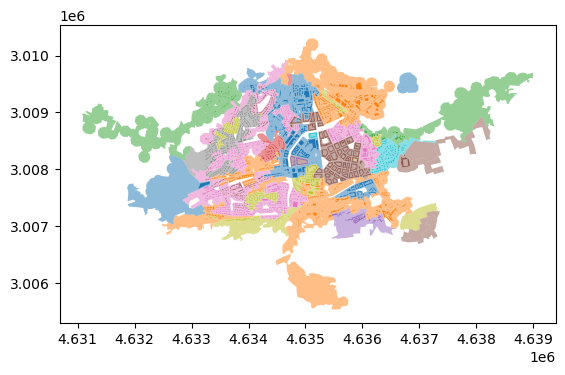

In [49]:
ax = morphotope_subset.plot(column='level_6_label', categorical=True, alpha=.5)
buildings_subset.plot(column='level_6_label', categorical=True, ax=ax)